# Preprocessing of data

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import datetime
import matplotlib.pyplot as plt

pathDynamicData = "Mobility/dynamische_Verkehrsdaten/"

## Dynamic countrates
As a first step, preprocess the dynamic data by loading an additional xml-file to identify the location corresponding to the coles. Further a new data frame is created, containing the latitude, longitude for each cole. 

In [2]:
def prepareDynData(pathAndFilename,
                   pathToXML=f"{pathDynamicData}Statische_Detektordaten.xml"):
    """
    Read and preprocess data from dynamic countrates.
        Input: 
            pathAndFilename - Path to file containing the data
            pathToXML - Path to xml file
        Returns: 
            df_filtered - data frame of the filtered data
            dfLocation - data frame of the filtered data (ID as index)
    """
    # Open data as data frame
    df = pd.read_csv(pathAndFilename, sep="\t", encoding='latin1', low_memory=False
                     , parse_dates=["DaySecFrom(UTC)", "DaySecTo(UTC)"])
    df = df[df["Number"] != "########"]

    # Open xml file
    xmlTree = ET.parse(pathToXML)
    root = xmlTree.getroot()

    # Get from records the identification ID and map these to location 
    IDList = []
    lat = {}
    lon = {}

    for record in root.findall(".//{http://datex2.eu/schema/2/2_0}measurementSiteRecord"):
        identification = record.findall(".//{http://datex2.eu/schema/2/2_0}measurementSiteIdentification");
        if len(identification) is not 1:
            print("More IDs per site. Take first one.")

        coordinates = record.find(".//{http://datex2.eu/schema/2/2_0}pointCoordinates")

        #ID.append(identification[0].text)
        ID = identification[0].text.split("[")[0]
        IDList.append(int(ID))
        lat[int(ID)] = float(coordinates.find(".//{http://datex2.eu/schema/2/2_0}latitude").text)
        lon[int(ID)] = float(coordinates.find(".//{http://datex2.eu/schema/2/2_0}longitude").text)

    # Only consider those coles, where location information is available
    df = df[df["ElemUID"].isin(IDList)]

    # Create data frame with location info
    dfLocation = pd.DataFrame()
    dfLocation["ElemUID"] = df["ElemUID"]
    dfLocation = dfLocation.drop_duplicates("ElemUID")
    
    dfLocation["Lat"] = dfLocation["ElemUID"]
    dfLocation["Lon"] = dfLocation["ElemUID"]
    
    dfLocation.set_index("ElemUID", inplace=True)
  
    dfLocation = dfLocation.replace({"Lat": lat})
    dfLocation = dfLocation.replace({"Lon": lon})
    
    return df, dfLocation

## Run the preprocessing and save data (TODO)

In [3]:
file = f"{pathDynamicData}FFM_DZG_180701/FFM_DEZ_180701.csv"

In [4]:
df_before = pd.read_csv(file, sep="\t", encoding='latin1', low_memory=False
                     , parse_dates=["DaySecFrom(UTC)", "DaySecTo(UTC)"])
df_before.ElemUID = pd.to_numeric(df_before.ElemUID, downcast='integer').apply(str)
df_before.describe(include='all')

,ElemUID,ElemName,Kind,Number,DaySecFrom(UTC),DaySecTo(UTC)
count,3466925,3466925,3466925,1449977,3466925,3466925
unique,2315,656,1,165,1440,1440
top,17382008,D1 (KFZ1),DEZ,60.00,2018-07-01 01:03:00,2018-07-01 01:47:00
freq,1499,161892,3466925,553334,4601,4601
first,NaN,NaN,NaN,NaN,2018-06-30 23:59:00,2018-07-01 00:00:00
last,NaN,NaN,NaN,NaN,2018-07-01 23:58:00,2018-07-01 23:59:00


Note that in the original dataframe we about 3.5 M data points for 2315 different UIDs.

In [5]:
df_filtered, dfLocation = prepareDynData(file)

In [6]:
print(df_filtered.shape)
df_filtered.head()

(1073974, 6)


,ElemUID,ElemName,Kind,Number,DaySecFrom(UTC),DaySecTo(UTC)
0,15424002,D2,DEZ,120.00,2018-07-01 23:58:00,2018-07-01 23:59:00
1,17790006,D6 (KFZ4),DEZ,120.00,2018-07-01 23:58:00,2018-07-01 23:59:00
2,17392004,D4,DEZ,NaN,2018-07-01 23:58:00,2018-07-01 23:59:00
3,18301005,D5 (2),DEZ,NaN,2018-07-01 23:58:00,2018-07-01 23:59:00
4,18297002,D2 (1),DEZ,60.00,2018-07-01 23:58:00,2018-07-01 23:59:00


In [7]:
print(dfLocation.shape)
dfLocation.head()

(719, 2)


,Lat,Lon
ElemUID,,
15424002,50.114246,8.651046
17790006,50.096250,8.659665
17392004,50.084656,8.632699
18301005,50.125027,8.675284
18297002,50.119923,8.677420


## Get amount of cars per 30 minutes

We have given the data every 1-2 minutes for every induction loop. However, we only want a granularity of 30 minutes, because the air polution data is only given in this granularity. The result will be a data frame containing for each timestamp (granularity: 30 min) the amount of cars at each induction loop, respectively.
 
Goal: We only want a granularity of 30 minutes.

In [8]:
df_amount_cars = df_filtered.copy()

In [9]:
df_amount_cars.ElemUID = pd.to_numeric(df_amount_cars.ElemUID, downcast='integer')
df_amount_cars.Number = pd.to_numeric(df_amount_cars.Number).fillna(0).astype(int)
df_amount_cars['Period'] = df_amount_cars['DaySecTo(UTC)'] - df_amount_cars['DaySecFrom(UTC)']
df_amount_cars.Period = (df_amount_cars.Period.dt.seconds / 60).astype(int)
# NaN corresponds to 0 count rates
df_amount_cars.Number = (df_amount_cars.Number * df_amount_cars.Period / 60).astype(int)
#add 1 hour, because date in UTC+0 and air polution data is in MEZ. TODO: summer/winter time
df_amount_cars['Timestamp'] = df_amount_cars['DaySecTo(UTC)'] + datetime.timedelta(hours=1)
df_amount_cars = df_amount_cars.drop(['ElemName', 'Kind', 'DaySecFrom(UTC)'
                                      , 'DaySecTo(UTC)', 'Period'], axis=1)
df_amount_cars.head()

,ElemUID,Number,Timestamp
0,15424002,2,2018-07-02 00:59:00
1,17790006,2,2018-07-02 00:59:00
2,17392004,0,2018-07-02 00:59:00
3,18301005,0,2018-07-02 00:59:00
4,18297002,1,2018-07-02 00:59:00


In [10]:
def round_up_date_to_half_hours(dt):
    if ((dt.minute == 30 or dt.minute == 0) and dt.second == 0):
        return str(dt)
    if (dt.minute < 30):
        return datetime.datetime(dt.year, dt.month, dt.day, dt.hour, 30).isoformat(' ')
    if (dt.hour < 23):
        return datetime.datetime(dt.year, dt.month, dt.day, dt.hour + 1).isoformat(' ')
    if (getattr(dt, 'is_year_end')):
        return datetime.datetime(dt.year+1, 1, 1).isoformat(' ')
    if (getattr(dt, 'is_month_end')):
        return datetime.datetime(dt.year, dt.month + 1, 1).isoformat(' ')
    else:
        return datetime.datetime(dt.year, dt.month, dt.day + 1).isoformat(' ')

In [11]:
df_amount_cars.Timestamp = df_amount_cars.Timestamp.apply(
    lambda dt: round_up_date_to_half_hours(dt))
df_amount_cars.head()

,ElemUID,Number,Timestamp
0,15424002,2,2018-07-02 01:00:00
1,17790006,2,2018-07-02 01:00:00
2,17392004,0,2018-07-02 01:00:00
3,18301005,0,2018-07-02 01:00:00
4,18297002,1,2018-07-02 01:00:00


In [12]:
df_amount_cars = df_amount_cars.groupby(
    ['ElemUID', 'Timestamp'])['Number'].sum().reset_index(name = 'Total_Cars')
df_amount_cars.shape
df_amount_cars.head()

,ElemUID,Timestamp,Total_Cars
0,14029001,2018-07-01 01:00:00,1
1,14029001,2018-07-01 01:30:00,29
2,14029001,2018-07-01 02:00:00,26
3,14029001,2018-07-01 02:30:00,44
4,14029001,2018-07-01 03:00:00,30


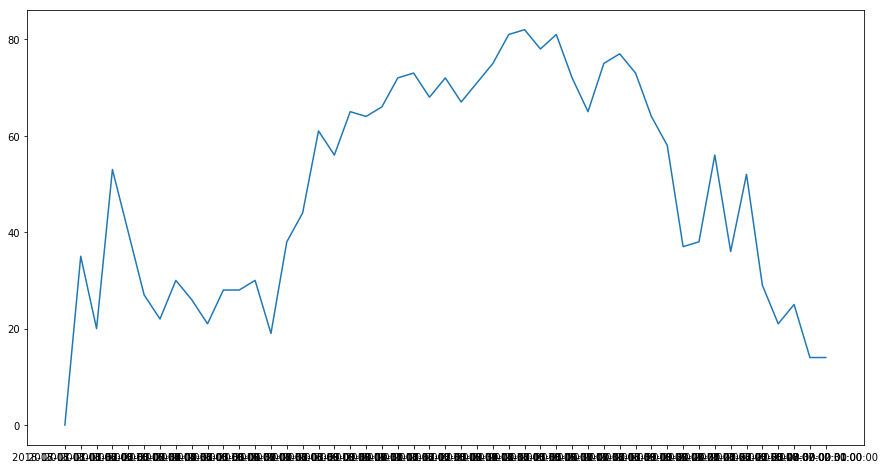

In [13]:
df_one_id = df_amount_cars[df_amount_cars.ElemUID == 18940002]
plt.figure(figsize=(15,8))
plt.plot(df_one_id['Timestamp'], df_one_id.Total_Cars)

Note that the 2018-07-01 was a Saturday. Therefore the peak is not in the morning (as on weekdays), but in the afternoon.

In [14]:
df_amount_cars = df_amount_cars.pivot(index='Timestamp', columns='ElemUID'
                                      , values='Total_Cars')

In [15]:
df_amount_cars.shape
df_amount_cars.head()

ElemUID,14029001,14029002,14029003,14029004,14029005,14029006,14029007,14029009,14029010,15050001,...,483492747,483492749,483492750,483492751,483492752,483492753,483492754,483492755,483492756,483492758
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-01 01:00:00,1.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0
2018-07-01 01:30:00,29.0,63.0,71.0,19.0,32.0,16.0,19.0,20.0,14.0,0.0,...,75.0,2.0,28.0,15.0,7.0,11.0,38.0,79.0,29.0,51.0
2018-07-01 02:00:00,26.0,61.0,46.0,21.0,29.0,18.0,16.0,18.0,11.0,0.0,...,48.0,9.0,23.0,16.0,15.0,7.0,42.0,64.0,24.0,33.0
2018-07-01 02:30:00,44.0,78.0,95.0,34.0,54.0,34.0,34.0,30.0,20.0,0.0,...,48.0,8.0,11.0,18.0,5.0,12.0,37.0,64.0,16.0,34.0
2018-07-01 03:00:00,30.0,91.0,91.0,32.0,48.0,28.0,26.0,30.0,26.0,0.0,...,27.0,1.0,15.0,9.0,7.0,8.0,34.0,43.0,21.0,26.0


After preprocessing, we are left with 719 induction loops (for about 70% we have no location given).